In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler


2022-11-19 13:05:35.284819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:

pb_df = pd.read_csv('/Users/miked/Downloads/powerball.csv')
pb_df.columns = ["Game", "Month", "Day", "Year", "No. 1", "No. 2", "No. 3", "No. 4", "No. 5", "PB", "PP"]
pb_df.drop("PP", inplace=True, axis=1)
pb_df.drop("Game", inplace=True, axis=1)
pb_df.sort_values()
dup_num = pb_df.pivot_table(columns=['PB'], aggfunc='size')
print(pb_df)
dup_num.head(40)


      Month  Day  Year  No. 1  No. 2  No. 3  No. 4  No. 5  PB
0         2    6  2010     22     54     52     14     59   4
1         2   10  2010     29      8     37     38      5  34
2         2   13  2010     14     10     40     51     30   1
3         2   17  2010     36      7     26      8     19  15
4         2   20  2010     13     54     41     37     27  32
...     ...  ...   ...    ...    ...    ...    ...    ...  ..
1393     11    5  2022     69     53     45     56     28  20
1394     11    7  2022     56     41     33     47     10  10
1395     11    9  2022     14     24      7     30     56   7
1396     11   12  2022     58     57     20     44     16   6
1397     11   14  2022     54     67     19     53     35  21

[1398 rows x 9 columns]


PB
1     45
2     43
3     45
4     49
5     49
6     50
7     46
8     48
9     42
10    49
11    49
12    41
13    50
14    45
15    44
16    44
17    47
18    60
19    49
20    46
21    43
22    41
23    40
24    64
25    49
26    47
27    19
28    14
29    27
30    15
31    11
32    16
33    22
34    13
35    15
36     7
37     3
38     5
39     6
dtype: int64

In [4]:
def get_data_local_csv():
    """
    Request user input. Read in then clean/transform data from a local CSV file.

    This function asks the user to imput a valid stock symbol from the list provided.
    Valid symbols can be entered in lower, upper or mixed case. 
    It takes that input and reads in data from the corrosponding local .csv file. 
    It then cleans/transforms the data into a pandas dataframe.
    The user only gets three attempts to enter a valid stock symbol from the list provided and 
    then the function terminates and returns a message.
    If no corrosponding file is found the function terminates and returns a message.
    

    Parameters
    ----------
    None

    Returns
    -------
    pandas dataframe

    Examples
    --------
    MSFT, AAPL
    """ 
    
    try: # Handles the condition of no dataframe returned (UnboundLocalError) due to no valid input after 3 attempts or file not found error.
        try: # Handles the conditions of a either a valid or invalid input or a FileNotFound error.
            for x in range(3): # Sets the input attempt range to 3 to avoid an infinite run condition.
                symbols = ['AAPL', 'AMD', 'AMZN', 'CSCO', 'META', 'MSFT', 'NFLX', 'QCOM', 'SBUX', 'TSLA'] # List of valid stock symbols for input.
                symbol = input("Please enter one of the following symbols!" + str(symbols)).upper() # User input statement.
                print("User selected " + symbol)
                if symbol in symbols: # Checks for valid input.
                    df = pd.read_csv('assets/HistoricalData_' + symbol + '.csv') # Read in data from local CSV file.
                    df['Symbol'] = symbol # Adds the "Symbol" column to the dataframe.
                    df['Open'] = df['Open'].str.replace("$", '', regex=True).astype(float) # Removes the $ from the data in the column and sets type to float.
                    df['High'] = df['High'].str.replace("$", '', regex=True).astype(float) # Removes the $ from the data in the column and sets type to float.
                    df['Low'] = df['Low'].str.replace("$", '', regex=True).astype(float) # Removes the $ from the data in the column and sets type to float.
                    df['Close/Last'] = df['Close/Last'].str.replace("$", '', regex=True).astype(float) # Removes the $ from the data in the column and sets type to float.
                    df.rename(columns={'Close/Last': 'Close'}, inplace=True) # Renames "Close/Last" column to "Close"
                    df['Date'] = pd.to_datetime(df['Date']) # Sets "Date" column to type datetime.
                    df['Year'] = df['Date'].dt.year # The next 6 rows seperates the "Date" column into it's individual components.
                    df['Month'] = df['Date'].dt.month
                    df['Day'] = df['Date'].dt.day
                    df['Week Num'] = df.Date.apply(lambda x:x.isocalendar()[1])
                    df['Day Num'] = df['Date'].dt.day_of_week
                    df['Day Name'] = df['Date'].dt.day_name()
                    break # Breaks loop on successful execution.
                elif x < 2: # Checks range variable for value on unsuccessful execution.
                    print("You have entered an invalid symbol! Please try again!") 
                else: # Informs user that the function is terminating after 3 invalid entries.
                    print("Function terminates after three invalid entries!")
                
        except FileNotFoundError: 
            print("File Not Found!")
        return df # Returns pandas dataframe on successful execution.

    except UnboundLocalError:
        print("No dataframe returned!")

In [5]:
def filter_by_year():
    """
    Requests user input. Reads in then cleans/transforms data from a local CSV file.

    This function calls the get_data_local_csv() function and then asks the user to imput a valid symbol and year from the list provided. 
    It takes that input and filters the current dataframe. 
    The user only gets three attempts to enter a valid year from the list provided and 
    then the function terminates and returns a message.
    If the dataframe is not returned a message is printed.

    Parameters
    ----------
    None

    Returns
    -------
    pandas dataframe

    Examples
    --------
    2012, 2022
    """

    df = get_data_local_csv()
    try:
        for x in range(3): # Sets the input attempt range to 3 to avoid an infinite run condition.
            years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'] # List of valid years for input.
            year = input("Please enter one of the following years!" + str(years)) # User input statement.
            print("User selected " + year)
            if year in years: # Checks for valid input.
                is_year = df["Year"] == int(year) # Filter dataframe to only requested year.
                df_yr = df[is_year]
                break # Breaks loop on successful execution.
            elif x < 2: # Checks range variable for value on unsuccessful execution.
                print("You have entered an invalid year! Please try again!") 
            else: # Informs user that the function is terminating after 3 invalid entries.
                print("Function terminates after three invalid entries!")

        return df_yr # Returns pandas dataframe on successful execution.

    except UnboundLocalError:
        print("No dataframe returned!")

User selected AAPL
User selected 2020
140/140 - 5s - loss: 0.0205 - 5s/epoch - 34ms/step
2/2 [==============================] - 1s 8ms/step


/var/folders/g9/c_5_0s1s5xx5fg76z29fxz5c0000gn/T/ipykernel_29081/3622094408.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_stock_price


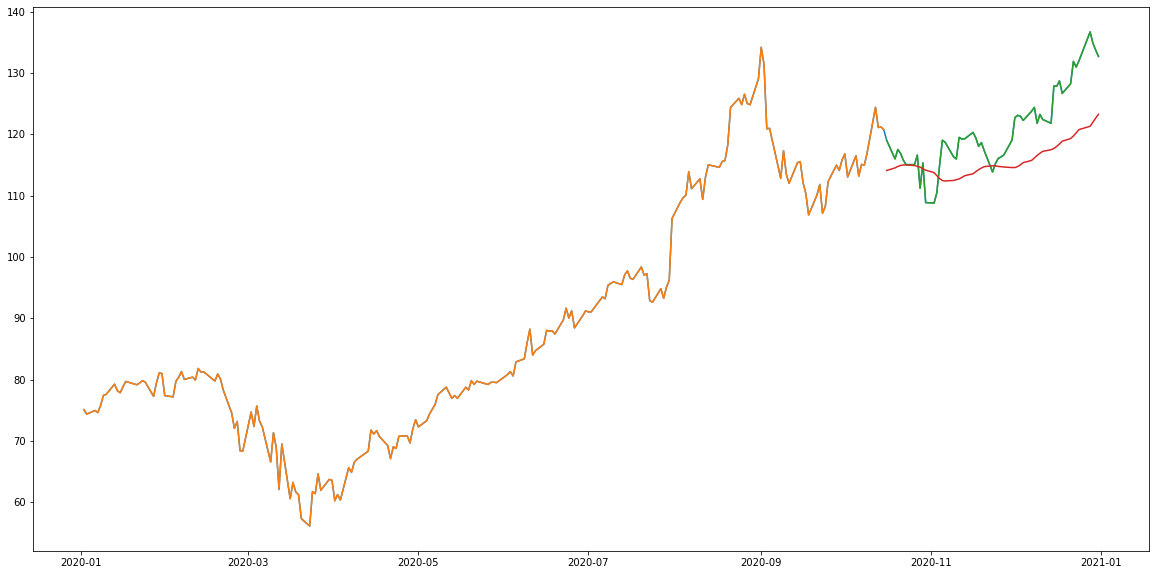

In [24]:
df = filter_by_year()
df.index = df["Date"]

plt.plot(df["Close"],label='Close Price history')

df = df.sort_index(ascending=True,axis=0)
data = pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    data["Date"][i]=df['Date'][i]
    data["Close"][i]=df["Close"][i]
data.head()

scaler=MinMaxScaler(feature_range=(0,1))
data.index=data.Date
data.drop("Date",axis=1,inplace=True)
final_data = data.values
train_data=final_data[0:200,:]
valid_data=final_data[200:,:]
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_data)
x_train_data,y_train_data=[],[]
for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(np.shape(x_train_data)[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))
model_data=data[len(data)-len(valid_data)-60:].values
model_data=model_data.reshape(-1,1)
model_data=scaler.transform(model_data)

lstm_model.compile(loss="mean_squared_error",optimizer="adam")
x_train_data = np.asarray(x_train_data)
y_train_data = np.asarray(y_train_data)
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)
X_test=[]
for i in range(60,model_data.shape[0]):
    X_test.append(model_data[i-60:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predicted_stock_price=lstm_model.predict(X_test)
predicted_stock_price=scaler.inverse_transform(predicted_stock_price)

train_data=data[:200]
valid_data=data[200:]
valid_data['Predictions']=predicted_stock_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

# Testing Changes